In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split

In [3]:
data = pd.read_csv('train_1.csv')
test_data = pd.read_csv('test_1.csv')

In [4]:
sub = pd.read_csv('sample_submission_24jSKY6.csv')

In [5]:
sub.head()

,UniqueID,loan_default
0,655269,0
1,723482,0
2,758529,0
3,763449,0
4,708663,0


In [6]:
test_id = sub['UniqueID']

In [7]:
len(test_data)

112392

In [8]:
data.head()

,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,State_ID,Employee_code_ID,Aadhar_flag,...,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default,age,d.o.b,m.o.b,ds.o.b,cred,Employment.Type_Salaried,Employment.Type_Self employed
0,50578,58400,89.55,67,22807,45,1441,6,1998,1,...,1,0,0,35.0,8,3,3,1,1,0
1,47145,65550,73.23,67,22807,45,1502,6,1998,1,...,0,0,1,33.0,26,9,2,1,0,1
2,53278,61360,89.63,67,22807,45,1497,6,1998,1,...,1,0,0,33.0,8,1,0,1,0,1
3,57513,66113,88.48,67,22807,45,1501,6,1998,1,...,0,1,1,25.0,26,10,4,1,0,1
4,52378,60300,88.39,67,22807,45,1495,6,1998,1,...,1,1,1,41.0,26,9,2,1,0,1


In [51]:
data['Employee_code_ID'].nunique()

3270

# FE

In [10]:
data['A_d'] = (data['asset_cost'] / data['disbursed_amount']) * data['ltv']
# for test set
test_data['A_d'] = (test_data['asset_cost'] / test_data['disbursed_amount']) * test_data['ltv']

In [11]:
data['As_di'] = data['asset_cost'] - data['disbursed_amount']
# for test set
test_data['As_di'] = test_data['asset_cost'] - test_data['disbursed_amount']

In [12]:
data['As_age'] = data['ltv'] * data['age']
# for test set
test_data['As_age'] = test_data['ltv'] * test_data['age']

In [13]:
data['PRI.ACTIVE.ACCTS'] = [0 if values == 0 else 1 for values in data['PRI.ACTIVE.ACCTS']]
# for test set
test_data['PRI.ACTIVE.ACCTS'] = [0 if values == 0 else 1 for values in test_data['PRI.ACTIVE.ACCTS']]

In [14]:
data['SEC.ACTIVE.ACCTS'] = [0 if values == 0 else 1 for values in data['SEC.ACTIVE.ACCTS']]
# for test set
test_data['SEC.ACTIVE.ACCTS'] = [0 if values == 0 else 1 for values in test_data['SEC.ACTIVE.ACCTS']]

In [15]:
data['sec_pri'] = data['SEC.ACTIVE.ACCTS'] * data['PRI.ACTIVE.ACCTS']
# for test set
test_data['As_di'] = test_data['SEC.ACTIVE.ACCTS'] * test_data['PRI.ACTIVE.ACCTS']

In [29]:
test_data['sec_pri'] = test_data['SEC.ACTIVE.ACCTS'] * test_data['PRI.ACTIVE.ACCTS']

In [54]:
data['mean_pincode_ass'] = data['Current_pincode_ID'].map(data.groupby('Current_pincode_ID')['asset_cost'].mean())
test_data['mean_pincode_ass'] = test_data['Current_pincode_ID'].map(test_data.groupby('Current_pincode_ID')['asset_cost'].mean())

In [55]:
data['mean_state_ass'] = data['State_ID'].map(data.groupby('State_ID')['asset_cost'].mean())
test_data['mean_state_ass'] = test_data['State_ID'].map(test_data.groupby('State_ID')['asset_cost'].mean())

In [56]:
data['mean_supply_ass'] = data['supplier_id'].map(data.groupby('supplier_id')['asset_cost'].mean())
test_data['mean_supply_ass'] = test_data['supplier_id'].map(test_data.groupby('supplier_id')['asset_cost'].mean())

In [57]:
data['mean_man_ass'] = data['manufacturer_id'].map(data.groupby('manufacturer_id')['asset_cost'].mean())
test_data['mean_man_ass'] = test_data['manufacturer_id'].map(test_data.groupby('manufacturer_id')['asset_cost'].mean())

In [58]:
data['mean_bra_ass'] = data['branch_id'].map(data.groupby('branch_id')['asset_cost'].mean())
test_data['mean_bra_ass'] = test_data['branch_id'].map(test_data.groupby('branch_id')['asset_cost'].mean())

In [59]:
data['mean_emp_ass'] = data['Employee_code_ID'].map(data.groupby('Employee_code_ID')['asset_cost'].mean())
test_data['mean_emp_ass'] = test_data['Employee_code_ID'].map(test_data.groupby('Employee_code_ID')['asset_cost'].mean())

In [16]:
data['mean_pincode'] = data['Current_pincode_ID'].map(data.groupby('Current_pincode_ID')['ltv'].mean())
test_data['mean_pincode'] = test_data['Current_pincode_ID'].map(test_data.groupby('Current_pincode_ID')['ltv'].mean())

In [17]:
data['mean_pincode_dis'] = data['Current_pincode_ID'].map(data.groupby('Current_pincode_ID')['disbursed_amount'].mean())
test_data['mean_pincode_dis'] = test_data['Current_pincode_ID'].map(test_data.groupby('Current_pincode_ID')['disbursed_amount'].mean())

In [18]:
data['mean_state'] = data['State_ID'].map(data.groupby('State_ID')['ltv'].mean())
test_data['mean_state'] = test_data['State_ID'].map(test_data.groupby('State_ID')['ltv'].mean())

In [19]:
data['mean_state_dis'] = data['State_ID'].map(data.groupby('State_ID')['disbursed_amount'].mean())
test_data['mean_state_dis'] = test_data['State_ID'].map(test_data.groupby('State_ID')['disbursed_amount'].mean())

In [43]:
data['mean_supply_dis'] = data['supplier_id'].map(data.groupby('supplier_id')['disbursed_amount'].mean())
test_data['mean_supply_dis'] = test_data['supplier_id'].map(test_data.groupby('supplier_id')['disbursed_amount'].mean())

In [44]:
data['mean_supply_ltv'] = data['supplier_id'].map(data.groupby('supplier_id')['ltv'].mean())
test_data['mean_supply_ltv'] = test_data['supplier_id'].map(test_data.groupby('supplier_id')['ltv'].mean())

In [46]:
data['mean_man_dis'] = data['manufacturer_id'].map(data.groupby('manufacturer_id')['disbursed_amount'].mean())
test_data['mean_man_dis'] = test_data['manufacturer_id'].map(test_data.groupby('manufacturer_id')['disbursed_amount'].mean())

In [47]:
data['mean_man_ltv'] = data['manufacturer_id'].map(data.groupby('manufacturer_id')['ltv'].mean())
test_data['mean_man_ltv'] = test_data['manufacturer_id'].map(test_data.groupby('manufacturer_id')['ltv'].mean())

In [49]:
data['mean_bra_dis'] = data['branch_id'].map(data.groupby('branch_id')['disbursed_amount'].mean())
test_data['mean_bra_dis'] = test_data['branch_id'].map(test_data.groupby('branch_id')['disbursed_amount'].mean())

In [50]:
data['mean_bra_ltv'] = data['branch_id'].map(data.groupby('branch_id')['ltv'].mean())
test_data['mean_bra_ltv'] = test_data['branch_id'].map(test_data.groupby('branch_id')['ltv'].mean())

In [52]:
data['mean_emp_dis'] = data['Employee_code_ID'].map(data.groupby('Employee_code_ID')['disbursed_amount'].mean())
test_data['mean_emp_dis'] = test_data['Employee_code_ID'].map(test_data.groupby('Employee_code_ID')['disbursed_amount'].mean())

In [53]:
data['mean_emp_ltv'] = data['Employee_code_ID'].map(data.groupby('Employee_code_ID')['ltv'].mean())
test_data['mean_emp_ltv'] = test_data['Employee_code_ID'].map(test_data.groupby('Employee_code_ID')['ltv'].mean())

## building model

In [62]:
X = data.drop('loan_default', axis=1)
y = data['loan_default']

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=17)

In [32]:
#rf = RandomForestClassifier(max_depth=15, n_estimators=400,max_features='auto',random_state=999,oob_score=True, n_jobs=-1)

In [33]:
##for i in range(5):
   # xg= XGBClassifier(max_depth=10, learning_rate=0.01, n_estimators=200,n_jobs=-1, nthread=4, gamma=0.7, random_state=i,
                  #scale_pos_weight=0.7,colsample_bylevel=0.7)

In [34]:
for i in range(20):
    model = CatBoostClassifier(iterations=250, 
                               learning_rate=0.1, 
                               random_seed=i,
                               logging_level='Silent',
                               loss_function='Logloss',
                               eval_metric='AUC',
                               one_hot_max_size=5)   

In [25]:
from sklearn.ensemble import VotingClassifier

In [26]:
#model1 = VotingClassifier(estimators=[('rf', rf), ('xg', xg)], voting='soft')

0:	test: 0.6066722	best: 0.6066722 (0)	total: 3.79s	remaining: 2h 6m 6s
50:	test: 0.6440468	best: 0.6440468 (50)	total: 1m 17s	remaining: 49m 13s
100:	test: 0.6513388	best: 0.6513388 (100)	total: 2m 10s	remaining: 40m 45s
150:	test: 0.6558615	best: 0.6558615 (150)	total: 2m 59s	remaining: 36m 32s
200:	test: 0.6590691	best: 0.6590691 (200)	total: 3m 49s	remaining: 34m 14s
250:	test: 0.6609562	best: 0.6609562 (250)	total: 4m 36s	remaining: 32m 7s
300:	test: 0.6626381	best: 0.6626381 (300)	total: 5m 26s	remaining: 30m 44s
350:	test: 0.6636739	best: 0.6636739 (350)	total: 6m 17s	remaining: 29m 34s
400:	test: 0.6647808	best: 0.6647808 (400)	total: 7m	remaining: 27m 56s
450:	test: 0.6655598	best: 0.6655598 (450)	total: 7m 46s	remaining: 26m 41s
500:	test: 0.6660911	best: 0.6660917 (499)	total: 8m 33s	remaining: 25m 36s
550:	test: 0.6665745	best: 0.6665745 (550)	total: 9m 22s	remaining: 24m 38s
600:	test: 0.6671876	best: 0.6671876 (600)	total: 10m 15s	remaining: 23m 51s
650:	test: 0.6675722	b

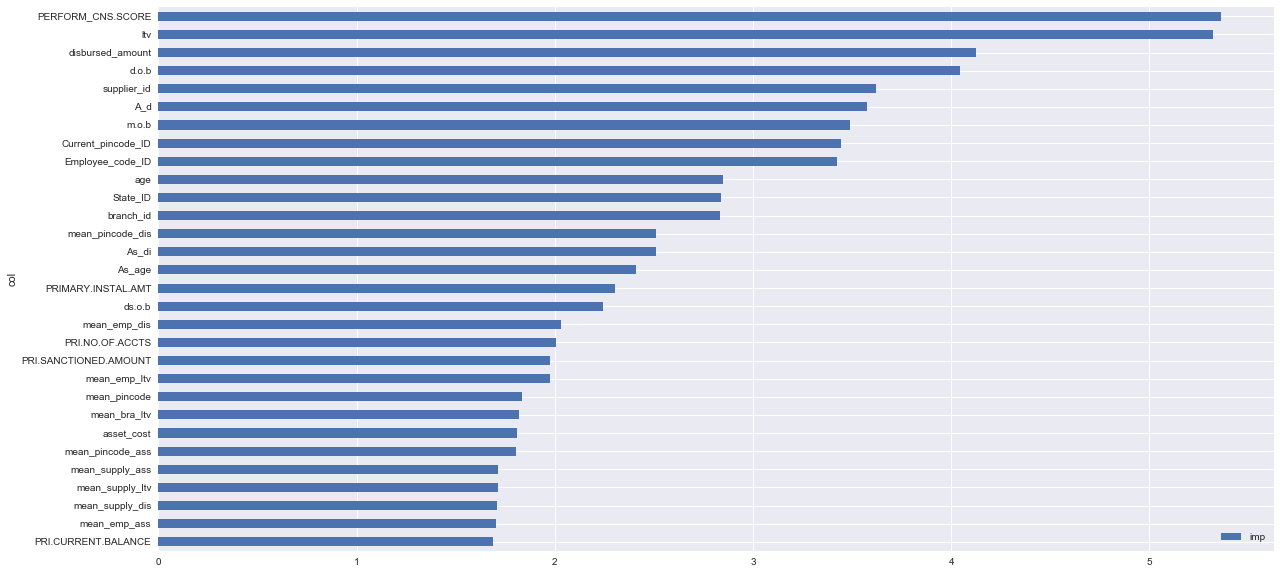

In [70]:
cb_model = CatBoostClassifier(iterations=2000,
                              learning_rate=0.02,
                              depth=10,
                              l2_leaf_reg=40,
                              bootstrap_type='Bernoulli',
                              subsample=0.7,
                              scale_pos_weight=5,
                              eval_metric='AUC',
                              metric_period=50,
                              od_type='Iter',
                              od_wait=45,
                              random_seed=17,
                              allow_writing_files=False)
cb_model.fit(X_train, y_train,
             eval_set=(X_test, y_test),
             use_best_model=True)

fea_imp = pd.DataFrame({'imp': cb_model.feature_importances_, 'col': X.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
_ = fea_imp.plot(kind='barh', x='col', y='imp', figsize=(20, 10))
plt.savefig('catboost_feature_importance.png')             

print('AUC:', roc_auc_score(y_test, cb_model.predict_proba(X_test)[:,1]))
y_preds = cb_model.predict_proba(test_data)[:,1]

In [ ]:
%%time
model.fit(X, y)

In [ ]:
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, confusion_matrix, auc, f1_score, classification_report

In [ ]:
pred = model.predict_proba(X_test)[:, 1]

## predicting test set

In [ ]:
x_test = test_data

In [ ]:
test_set_predictions = model.predict_proba(x_test)[:, 1] 

In [71]:
d = {'UniqueID':test_id, 'loan_default':y_preds} 

In [72]:
test_set = pd.DataFrame(d)

In [73]:
test_set.tail()   

,UniqueID,loan_default
112387,755547,0.555011
112388,716994,0.601199
112389,709352,0.517476
112390,699795,0.570022
112391,755244,0.376300


In [74]:
test_set.to_csv('d73.csv', index=False)